#### Библиотеки

In [1]:
print("feeffefe")

feeffefe


In [2]:
import requests
import matplotlib.pyplot as plt
import datetime
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import gym
from gym import spaces
from gym.envs.registration import register
import transformers
import torch
import sklearn
import yfinance as yf
import json
import time
import logging

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


#### Данные

In [3]:
symbol = 'INTC'
start_date = '2020-01-01'
end_date = '2023-07-05'

df_long = yf.download(symbol, start=start_date, end=end_date, interval='1d')

df_long = df_long.reset_index()
df_long['open'] = df_long['Open'].astype(float)
df_long['high'] = df_long['High'].astype(float)
df_long['low'] = df_long['Low'].astype(float)
df_long['close'] = df_long['Close'].astype(float)
df_long['adj_close'] = df_long['Adj Close'].astype(float)
df_long['volume'] = df_long['Volume'].astype(int)
df_long['date'] = df_long['Date'].astype(str)

df_long.dtypes

[*********************100%%**********************]  1 of 1 completed


Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume                int32
date                 object
dtype: object

In [4]:
df_pre = df_long[['date','close']]
df_pre.head()

,date,close
0,2020-01-02,60.840000
1,2020-01-03,60.099998
2,2020-01-06,59.930000
3,2020-01-07,58.930000
4,2020-01-08,58.970001


#### Yahoo

In [6]:
import yfinance as yf

symbol = 'INTC'
start_date = '2020-01-01'
end_date = '2023-07-05'

# Получите исторические данные из Yahoo Finance
df_long = yf.download(symbol, start=start_date, end=end_date, interval='1d')

df_long = df_long.reset_index()
df_long['open'] = df_long['Open'].astype(float)
df_long['high'] = df_long['High'].astype(float)
df_long['low'] = df_long['Low'].astype(float)
df_long['close'] = df_long['Close'].astype(float)
df_long['adj_close'] = df_long['Adj Close'].astype(float)
df_long['volume'] = df_long['Volume'].astype(int)
df_long['date'] = df_long['Date'].astype(str)

df_long.dtypes

[*********************100%%**********************]  1 of 1 completed


Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume                int32
date                 object
dtype: object

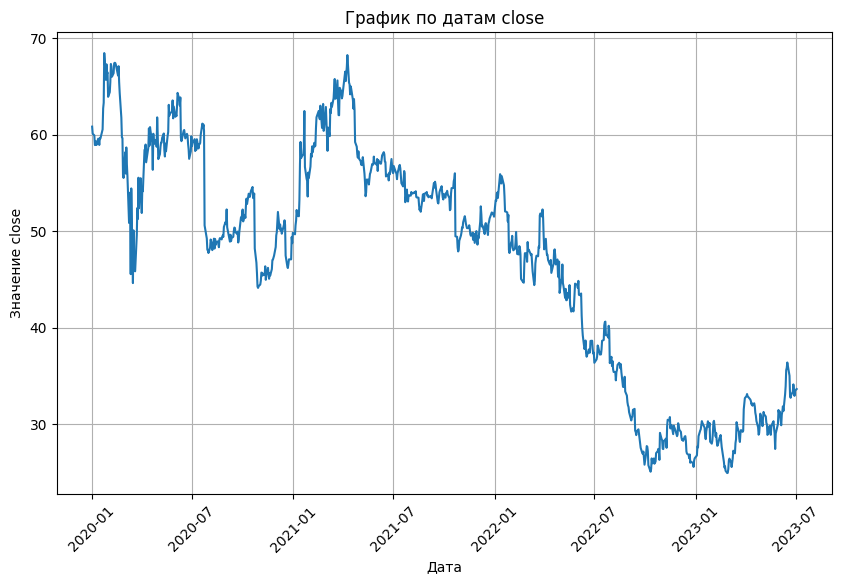

In [7]:
plt.figure(figsize=(10, 6))

# Постройте график
plt.plot(df_long['Date'], df_long['close'])
plt.title('График по датам close')
plt.xlabel('Дата')
plt.ylabel('Значение close')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

#### Препроцессинг

In [8]:
df_pre = df_long[['date','close']]
df_pre

,date,close
0,2020-01-02,60.840000
1,2020-01-03,60.099998
2,2020-01-06,59.930000
3,2020-01-07,58.930000
4,2020-01-08,58.970001
...,...,...
876,2023-06-27,34.099998
877,2023-06-28,33.570000
878,2023-06-29,32.910000
879,2023-06-30,33.439999


In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
datetime_object = str_to_datetime('1986-03-19')
datetime_object

In [ ]:
df_pre['date'] = df_pre['date'].apply(str_to_datetime)

<ipython-input-14-12d869df47f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['date'] = df_pre['date'].apply(str_to_datetime)


In [ ]:
df_pre = df_pre.set_index('date')
df_pre.head()

In [ ]:
def df_to_windowed_df(data, n=3):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['close'].shift(i)
    windowed_data['Target'] = data['close']
    return windowed_data.dropna()

In [ ]:
windowed_df = df_to_windowed_df(df_pre)
windowed_df = windowed_df.reset_index()
windowed_df

,date,Target-3,Target-2,Target-1,Target
0,2020-01-07,60.840000,60.099998,59.930000,58.930000
1,2020-01-08,60.099998,59.930000,58.930000,58.970001
2,2020-01-09,59.930000,58.930000,58.970001,59.299999
3,2020-01-10,58.930000,58.970001,59.299999,58.939999
4,2020-01-13,58.970001,59.299999,58.939999,59.590000
...,...,...,...,...,...
873,2023-06-27,32.709999,33.000000,33.340000,34.099998
874,2023-06-28,33.000000,33.340000,34.099998,33.570000
875,2023-06-29,33.340000,34.099998,33.570000,32.910000
876,2023-06-30,34.099998,33.570000,32.910000,33.439999


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

In [ ]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

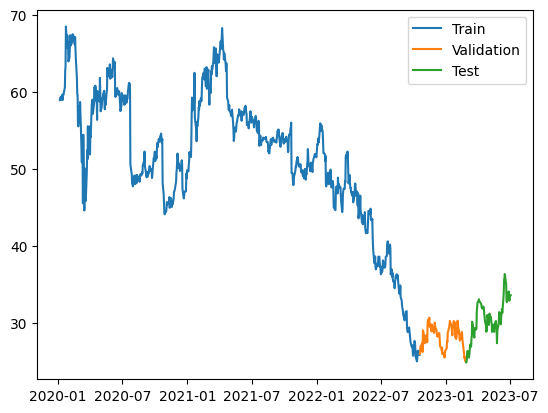

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

#### PRE-TRAINED LSTM

In [ ]:
# !ls /content/torch_model/suryaR-15/data

0  1  10  11  12  13  14  15  16  17  18  19  2  20  21  3  4  5  6  7	8  9


In [ ]:
# !rm -rf /content/torch_model/suryaR-15

##### Конфиг-файлы

In [ ]:
# config_data = """
# {
#   "input_dim": 1,
#   "hidden_dim": 64,
#   "num_layers": 5,
#   "output_dim": 1,
#   "num_epochs": 500
# }
# """

# # Запись данных в файл
# with open("/content/config.json", "w") as file:
#     file.write(config_data)

In [5]:
import torch
import torch.nn as nn

class LSTMStockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMStockPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

##### Загрузка модели

In [6]:
config_path = 'lstm_model/config.json'
model_weights_path = 'lstm_model/pytorch_model.bin'

# Загрузка параметров из config.json
with open(config_path, 'r') as f:
    config = json.load(f)

# Создание экземпляра модели
lstm_model = LSTMStockPredictor(
    input_dim=config['input_dim'],
    hidden_dim=config['hidden_dim'],
    num_layers=config['num_layers'],
    output_dim=config['output_dim']
)

# Загрузка весов модели
lstm_model.load_state_dict(torch.load(model_weights_path))
lstm_model.eval()  # Перевод модели в режим оценки

LSTMStockPredictor(
  (lstm): LSTM(1, 64, num_layers=5, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Загрузка данных
data = df_pre
data = data['close'].values.reshape(-1,1)  # Пример использования данных закрытия

# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Создание последовательностей для входных данных модели
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60  # Количество временных шагов для входной последовательности
X, y = create_dataset(data_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Преобразование для LSTM


##### Прогноз

In [8]:
# Прогноз
X_tensor = torch.tensor(X).float()
with torch.no_grad():
    predictions = lstm_model(X_tensor)
    predictions = predictions.numpy()

# Обратное масштабирование значений для получения истинных прогнозов
predictions_rescaled = scaler.inverse_transform(predictions)

In [9]:
df_stockdata = pd.DataFrame({
    'Real': data[-len(predictions_rescaled):].flatten(),
    'Predictions': predictions_rescaled.flatten()
})
df_stockdata['Deviations'] = df_stockdata['Real'] - df_stockdata['Predictions']
df_stockdata.head()

,Real,Predictions,Deviations
0,54.119999,52.585621,1.534378
1,51.880001,54.484596,-2.604595
2,54.349998,54.251961,0.098038
3,54.130001,52.165035,1.964966
4,58.430000,53.721729,4.708271


#### Визуализация рез-ов

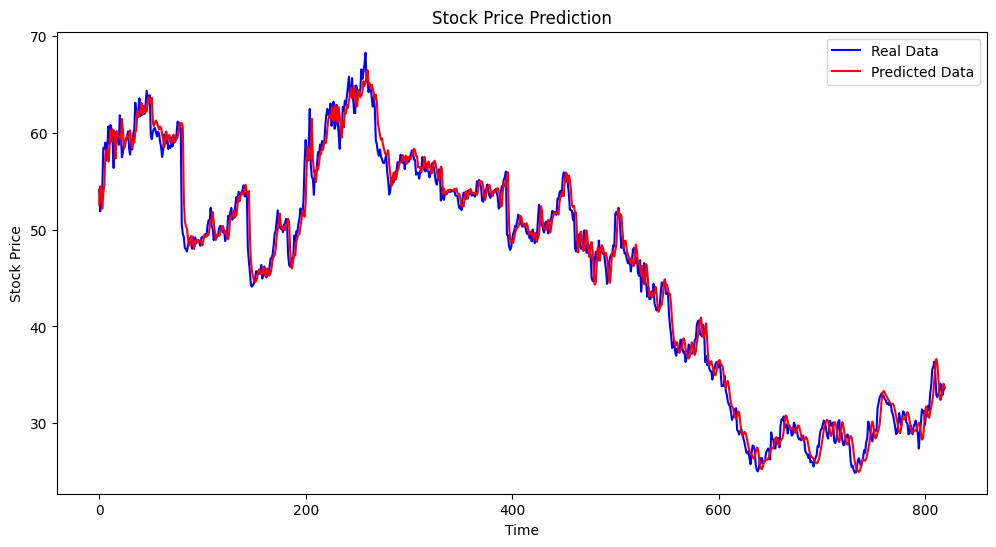

In [ ]:
# Отображение реальных данных и прогнозов на графике
plt.figure(figsize=(12, 6))
plt.plot(data[-len(predictions_rescaled):], label='Real Data', color='blue')  # Реальные данные
plt.plot(predictions_rescaled, label='Predicted Data', color='red')  # Прогнозируемые данные
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

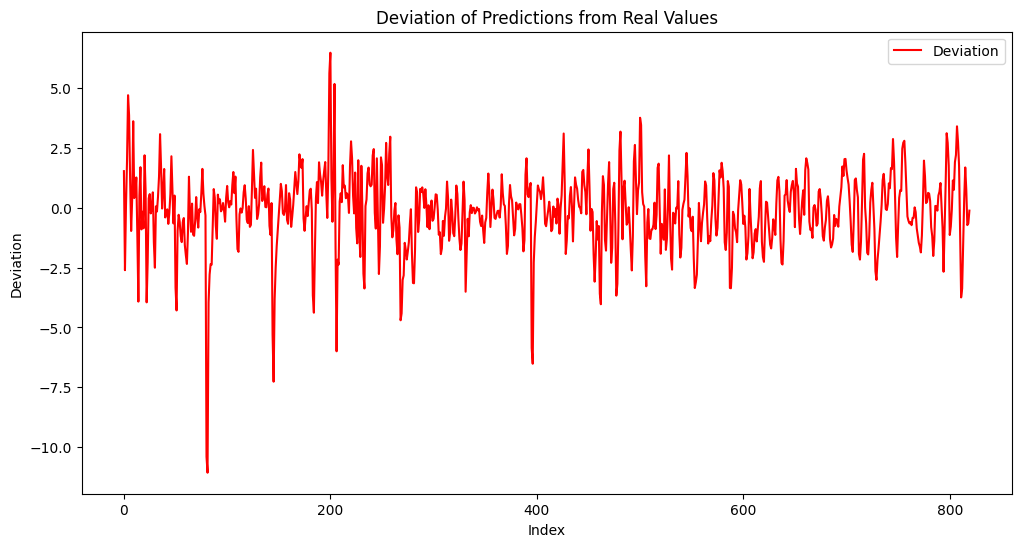

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_stockdata['Deviations'], label='Deviation', color='red')
plt.title('Deviation of Predictions from Real Values')
plt.xlabel('Index')
plt.ylabel('Deviation')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

def gini(actual, pred):
    assert len(actual) == len(pred)
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    total_losses = all[:, 0].sum()
    gini_sum = all[:, 0].cumsum().sum() / total_losses
    gini_sum -= (len(actual) + 1) / 2.
    return gini_sum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

gini_score = gini_normalized(df_stockdata['Real'].values, df_stockdata['Predictions'].values)

# Вычисление метрик
mse = mean_squared_error(df_stockdata['Real'], df_stockdata['Predictions'])
mae = mean_absolute_error(df_stockdata['Real'], df_stockdata['Predictions'])
r2 = r2_score(df_stockdata['Real'], df_stockdata['Predictions'])
msle = mean_squared_log_error(df_stockdata['Real'], df_stockdata['Predictions'])

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')
print(f'Normalized Gini Coefficient: {gini_score}')
print(f'Mean Squared Logarithmic Error: {msle}')

MSE: 2.5020799871532957
MAE: 1.1235980243217654
R²: 0.9819544229048033
Normalized Gini Coefficient: 0.9882301047846379
Mean Squared Logarithmic Error: 0.0012164655096395507


Основные статистические показатели:
             Real  Predictions  Deviations
count  820.000000   820.000000  820.000000
mean    46.064085    46.230289   -0.166205
std     11.782303    11.799667    1.574000
min     24.900000    24.978630  -11.070339
25%     33.537499    34.010495   -0.945453
50%     49.179998    49.321712   -0.067842
75%     55.217500    55.470852    0.761596
max     68.260002    66.451729    6.484081

Персентили:
           Real  Predictions  Deviations
0.05  26.969999    27.072523   -2.650751
0.25  33.537499    34.010495   -0.945453
0.50  49.179998    49.321712   -0.067842
0.75  55.217500    55.470852    0.761596
0.95  62.460499    62.327251    2.047715

Мода для 'Real':
26.969999313354492


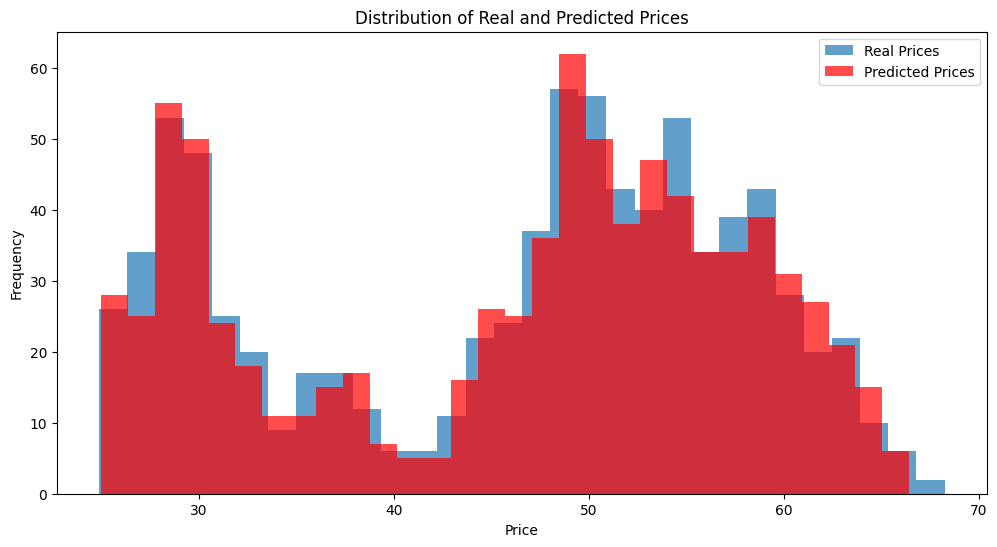

In [ ]:
# Статистический анализ
print("Основные статистические показатели:")
print(df_stockdata.describe())

# Персентили
print("\nПерсентили:")
print(df_stockdata.quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

# Мода
print("\nМода для 'Real':")
print(df_stockdata['Real'].mode().iloc[0])

plt.figure(figsize=(12, 6))
plt.hist(df_stockdata['Real'], bins=30, alpha=0.7, label='Real Prices')
plt.hist(df_stockdata['Predictions'], bins=30, alpha=0.7, label='Predicted Prices', color='red')
plt.title('Distribution of Real and Predicted Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Базовый торговый робот

In [ ]:
class SimpleTradingBot:
    def __init__(self, lstm_model, data):
        self.lstm_model = lstm_model
        self.data = data
        self.balance = 1000  # Начальный баланс
        self.position = 0  # Начальная позиция

    def predict(self, X):
        X_torch = torch.tensor(X, dtype=torch.float32)
        predictions = self.lstm_model(X_torch).detach().numpy()
        return predictions

    def trade(self):
        start_time = time.time()  # Замер начала времени
        for i in range(len(X)):
            current_price = self.data[i]
            prediction = self.predict(X[i:i+1])[0][0]
            if prediction > current_price:  # Если прогноз выше текущей цены
                self.buy(current_price)
            else:
                self.sell(current_price)
        end_time = time.time()  # Замер окончания времени
        duration = end_time - start_time  # Расчет длительности
        print()
        print(f'Время выполнения метода trade: {duration:.2f} секунд')

    def buy(self, price):
        self.position += 1
        self.balance -= price
        print(f'Купил по {price}, баланс: {self.balance}, позиция: {self.position}')

    def sell(self, price):
        self.position -= 1
        self.balance += price
        print(f'Продал по {price}, баланс: {self.balance}, позиция: {self.position}')

# Создаем экземпляр базового робота
simple_bot = SimpleTradingBot(lstm_model, data_scaled)
simple_bot.trade()

Продал по [0.82487949], баланс: [1000.82487949], позиция: -1
Продал по [0.80789528], баланс: [1001.63277477], позиция: -2
Продал по [0.80399356], баланс: [1002.43676833], позиция: -3
Продал по [0.78104199], баланс: [1003.21781032], позиция: -4
Продал по [0.78196007], баланс: [1003.99977039], позиция: -5
Продал по [0.78953405], баланс: [1004.78930444], позиция: -6
Продал по [0.78127147], баланс: [1005.5705759], позиция: -7
Продал по [0.79619002], баланс: [1006.36676592], позиция: -8
Продал по [0.79251777], баланс: [1007.1592837], позиция: -9
Продал по [0.78127147], баланс: [1007.94055516], позиция: -10
Продал по [0.79779662], баланс: [1008.73835179], позиция: -11
Купил по [0.7964195], баланс: [1007.94193229], позиция: -10
Продал по [0.81822351], баланс: [1008.7601558], позиция: -11
Продал по [0.86825794], баланс: [1009.62841374], позиция: -12
Продал по [0.88179937], баланс: [1010.51021311], позиция: -13
Продал по [1.], баланс: [1011.51021311], позиция: -14
Продал по [0.93619466], баланс

#### Робот DQN

In [ ]:
# batch_size=32
# эпизод: 818, награда: 0.004819808968338113, e: 0.6763948591909945
# Время выполнения метода trade: 761.79 секунд

import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

class DQNTradingBot:
    def __init__(self, lstm_model, data, state_size, action_size):
        self.lstm_model = lstm_model
        self.data = data
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def predict(self, X):
        X_torch = torch.tensor(X, dtype=torch.float32)
        predictions = self.lstm_model(X_torch).detach().numpy()
        return predictions

    def trade(self):
        start_time = time.time()  # Замер начала времени
        state = np.reshape(X[0], [1, self.state_size, 1])
        for time_step in range(len(X) - 1):
            action = self.act(state)  # Выбор действия на основе ε-жадной стратегии
            next_state = np.reshape(X[time_step + 1], [1, self.state_size, 1])  # Формирование следующего состояния
            reward = data_scaled[time_step + 1][0] - data_scaled[time_step][0]  # Расчет награды как разница в цене
            done = time_step == len(X) - 2  # Проверка на последний шаг
            self.remember(state, action, reward, next_state, done)  # Сохранение перехода в памяти
            state = next_state  # Переход к следующему состоянию

            if done:
                print(f'эпизод: {time_step}, награда: {reward}, e: {self.epsilon}')  # Вывод результатов по завершении эпизода
                break

            # Уменьшение частоты вызова replay: только каждые 10 шагов
            if len(self.memory) > batch_size and time_step % 10 == 0:
                self.replay(batch_size)  # Обучение модели на минибатче

        end_time = time.time()  # Замер окончания времени
        duration = end_time - start_time  # Расчет длительности
        print(f'Время выполнения метода trade: {duration:.2f} секунд или {duration/60:.2f} минут')

# Пример использования
state_size = look_back  # количество входных параметров
action_size = 2  # количество возможных действий (купить или продать)
dqn_bot = DQNTradingBot(lstm_model, data_scaled, state_size, action_size)

# Обучение и торговля DQN робота
batch_size = 32
dqn_bot.trade()

Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 58ms/step
эпизод: 818, награда: 0.004819808968338113, e: 0.6763948591909945
Время выполнения метода trade: 991.46 секунд


#### прошлогодняя LSTM

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

inputs = keras.Input(shape=(3, 1), name="input")
x = layers.LSTM(64)(inputs)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=x)

In [ ]:
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
22/22 [==============================] - 4s 48ms/step - loss: 2399.9639 - mean_absolute_error: 48.1172 - val_loss: 479.1438 - val_mean_absolute_error: 21.8428
Epoch 2/100
22/22 [==============================] - 0s 10ms/step - loss: 1753.7399 - mean_absolute_error: 40.6769 - val_loss: 67.7916 - val_mean_absolute_error: 8.0942
Epoch 3/100
22/22 [==============================] - 0s 11ms/step - loss: 631.6398 - mean_absolute_error: 22.2955 - val_loss: 344.5605 - val_mean_absolute_error: 18.5080
Epoch 4/100
22/22 [==============================] - 0s 12ms/step - loss: 95.9956 - mean_absolute_error: 7.4422 - val_loss: 637.2101 - val_mean_absolute_error: 25.2071
Epoch 5/100
22/22 [==============================] - 0s 11ms/step - loss: 79.0862 - mean_absolute_error: 6.8212 - val_loss: 311.3040 - val_mean_absolute_error: 17.6112
Epoch 6/100
22/22 [==============================] - 0s 9ms/step - loss: 44.4802 - mean_absolute_error: 5.2336 - val_loss: 50.3885 - val_mean_absolute_err

22/22 [==============================] - 0s 2ms/step


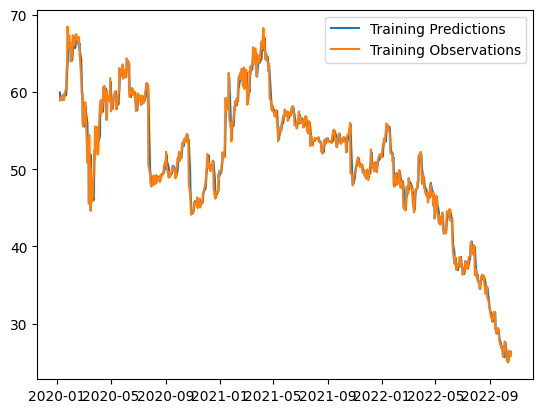

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 4ms/step


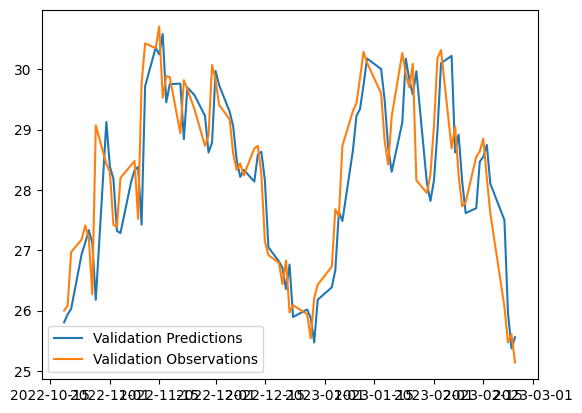

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 4ms/step


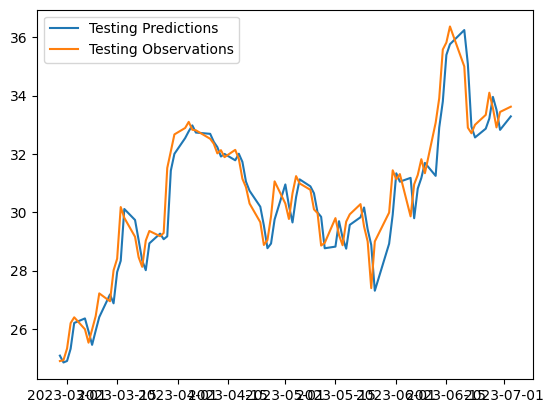

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

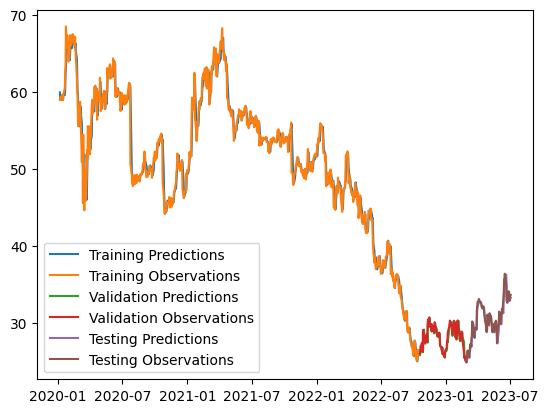

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
from google.colab import drive

# Подключение к Google Drive
drive.mount('/content/drive')
# Сохранение модели
model.save('/content/drive/MyDrive/LSTM_for_trade_bot.h5')

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Прогноз с использование предобученной модели

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.load_weights('/content/drive/MyDrive/LSTM_for_trade_bot.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = {
    'date': ['2023-07-17'],
    'Target-3': [60.09999847],
    'Target-2': [59.93000031],
    'Target-1': [58.93000031],
    'Target': [0]
}
df = pd.DataFrame(data)
df

,date,Target-3,Target-2,Target-1,Target
0,2023-07-17,60.099998,59.93,58.93,0


In [ ]:
dates_check, X_check, y_check = windowed_df_to_date_X_y(df)

In [ ]:
predictions = model.predict(X_check)

print(predictions)

1/1 [==============================] - 0s 23ms/step
[[59.05287]]


#### API песочницы тинька

#### ByBit

In [ ]:
# !pip install pybit

In [ ]:
!pip install pycrypto

In [ ]:
# !pip install pycryptodome

In [29]:
import requests

def get_external_ip():
    response = requests.get('https://api.ipify.org?format=json')
    if response.status_code == 200:
        ip = response.json()['ip']
        return print('fe')#ip
    else:
        raise Exception(f"Error fetching IP address: {response.status_code}")

# Пример использования
try:
    external_ip = get_external_ip()
    print(f"My external IP address is: {external_ip}")
except Exception as e:
    print(f"An error occurred: {e}")

fe
My external IP address is: None


In [16]:
from pybit.unified_trading import HTTP
from pybit import exceptions
import pprint
import concurrent.futures
import time

In [30]:
key="///"
secret="///"

In [18]:
cl = HTTP(
    testnet=True,
    api_key=key,
    api_secret=secret,
    recv_window=60000
)

In [92]:
print(cl.upgrade_to_unified_trading_account())

2024-05-26 16:43:31,416 Starting new HTTPS connection (1): api-testnet.bybit.com:443
2024-05-26 16:43:31,805 https://api-testnet.bybit.com:443 "POST /v5/account/upgrade-to-uta HTTP/1.1" 200 136


{'retCode': 0, 'retMsg': 'SUCCESS', 'result': {'unifiedUpdateStatus': 'SUCCESS', 'unifiedUpdateMsg': None}, 'retExtInfo': {}, 'time': 1716731011680}


In [125]:
logging.basicConfig(format="%(asctime)s %(message)s", level=logging.DEBUG)
r = cl.get_orderbook(category="linear", symbol="SOLUSDT")
print(r)

2024-05-26 17:34:33,809 Resetting dropped connection: api-testnet.bybit.com
2024-05-26 17:34:34,214 https://api-testnet.bybit.com:443 "GET /v5/market/orderbook?category=linear&symbol=SOLUSDT HTTP/1.1" 200 None


{'retCode': 0, 'retMsg': 'OK', 'result': {'s': 'SOLUSDT', 'b': [['164.28', '22625.4'], ['164.26', '51828.5'], ['164.24', '54828.5'], ['164.22', '28327.7'], ['164.2', '34888.5'], ['164.18', '62350.5'], ['164.16', '59741.4'], ['164.14', '33538'], ['164.12', '23976.1'], ['164.1', '57488.7'], ['164.08', '48899.1'], ['164.06', '37284.6'], ['164.04', '43239.7'], ['164.02', '49038.1'], ['164', '56409.7'], ['163.98', '24796'], ['163.96', '29877.8'], ['163.94', '46765'], ['163.92', '29537.3'], ['163.9', '36443.7'], ['163.88', '56227.9'], ['163.84', '28966.5'], ['163.8', '36645.9'], ['163.77', '0.1'], ['163.76', '57013.2']], 'a': [['164.3', '36462.5'], ['164.33', '54245'], ['164.34', '34282.2'], ['164.37', '28423.2'], ['164.38', '41128.6'], ['164.41', '6125.8'], ['164.42', '46343.6'], ['164.45', '22867.4'], ['164.46', '24162'], ['164.49', '65211.4'], ['164.53', '37936.1'], ['164.57', '34122.3'], ['164.61', '36041.6'], ['164.62', '0.1'], ['164.65', '61345.6'], ['164.69', '57587.9'], ['164.73', '4

In [126]:
pprint.pprint(r.get('result'))

{'a': [['164.3', '36462.5'],
       ['164.33', '54245'],
       ['164.34', '34282.2'],
       ['164.37', '28423.2'],
       ['164.38', '41128.6'],
       ['164.41', '6125.8'],
       ['164.42', '46343.6'],
       ['164.45', '22867.4'],
       ['164.46', '24162'],
       ['164.49', '65211.4'],
       ['164.53', '37936.1'],
       ['164.57', '34122.3'],
       ['164.61', '36041.6'],
       ['164.62', '0.1'],
       ['164.65', '61345.6'],
       ['164.69', '57587.9'],
       ['164.73', '48552.8'],
       ['164.77', '37933.6'],
       ['164.81', '64567.3'],
       ['164.85', '48886.4'],
       ['165.04', '0.1'],
       ['165.07', '39.4'],
       ['165.34', '0.1'],
       ['165.38', '0.5'],
       ['165.39', '0.1']],
 'b': [['164.28', '22625.4'],
       ['164.26', '51828.5'],
       ['164.24', '54828.5'],
       ['164.22', '28327.7'],
       ['164.2', '34888.5'],
       ['164.18', '62350.5'],
       ['164.16', '59741.4'],
       ['164.14', '33538'],
       ['164.12', '23976.1'],
       ['16

In [80]:
# symb = cl.query_symbol()
# print(symb)

In [108]:
account_info = cl.get_account_info()
print(account_info)

2024-05-26 16:53:18,151 Starting new HTTPS connection (1): api-testnet.bybit.com:443
2024-05-26 16:53:18,548 https://api-testnet.bybit.com:443 "GET /v5/account/info HTTP/1.1" 200 218


{'retCode': 0, 'retMsg': 'OK', 'result': {'marginMode': 'REGULAR_MARGIN', 'updatedTime': '1716234395000', 'unifiedMarginStatus': 4, 'dcpStatus': 'OFF', 'timeWindow': 10, 'smpGroup': 0, 'isMasterTrader': False, 'spotHedgingStatus': 'OFF'}}


In [133]:
balance = cl.get_wallet_balance(accountType='UNIFIED') #CONTRACT
pprint.pprint(balance)


2024-05-26 17:51:44,326 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 873


{'result': {'list': [{'accountIMRate': '0.0003',
                      'accountLTV': '0',
                      'accountMMRate': '0',
                      'accountType': 'UNIFIED',
                      'coin': [{'accruedInterest': '0',
                                'availableToBorrow': '',
                                'availableToWithdraw': '4998.45099227',
                                'bonus': '0',
                                'borrowAmount': '0.000000000000000000',
                                'coin': 'USDT',
                                'collateralSwitch': True,
                                'cumRealisedPnl': '-0.0032828',
                                'equity': '5000.1005172',
                                'locked': '0',
                                'marginCollateral': True,
                                'spotHedgingQty': '0',
                                'totalOrderIM': '0',
                                'totalPositionIM': '1.64952493',
         

In [121]:
coin_info = cl.get_coin_info(coin="SOL")
pprint.pprint(coin_info)

2024-05-26 16:57:31,694 https://api-testnet.bybit.com:443 "GET /v5/asset/coin/query-info?coin=SOL HTTP/1.1" 200 329


{'result': {'rows': [{'chains': [{'chain': 'SOL',
                                  'chainDeposit': '1',
                                  'chainType': 'Solana',
                                  'chainWithdraw': '',
                                  'confirmation': '1',
                                  'depositMin': '0',
                                  'minAccuracy': '8',
                                  'withdrawFee': '',
                                  'withdrawMin': '',
                                  'withdrawPercentageFee': ''}],
                      'coin': 'SOL',
                      'name': 'SOL',
                      'remainAmount': ''}]},
 'retCode': 0,
 'retExtInfo': {},
 'retMsg': '',
 'time': 1716731851523}


In [164]:
# размещение ордеров
try:
    r = cl.place_order(
            category="spot",
            symbol="ETHUSDT",#"SOLUSDT",
            side="BUY",
            orderType="Market",
            # qty=floor_price(avbl, 3),
            qty=10,
            # marketUnit="quoteCoin",
    )
    pprint.pprint(r)
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

2024-05-26 18:27:14,156 https://api-testnet.bybit.com:443 "POST /v5/order/create HTTP/1.1" 200 143


{'result': {'orderId': '1694509167735472640',
            'orderLinkId': '1694509167735472641'},
 'retCode': 0,
 'retExtInfo': {},
 'retMsg': 'OK',
 'time': 1716737234023}


In [168]:
# Настройка параметров отображения pandas
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.width', None)  # Не ограничивать ширину вывода
pd.set_option('display.max_colwidth', None)  # Не ограничивать ширину столбцов
pd.options.display.expand_frame_repr = False

In [169]:
try:
    r = cl.get_order_history(category="spot")
    order_list = r['result']['list']
    filtered_orders = []

    for order in order_list:
        filtered_order = {
            'orderId': order['orderId'],
            'createdTime': order['createdTime'],
            'symbol': order['symbol'],
            'basePrice': order['basePrice'],
            'qty': order['qty'],
            'rejectReason': order['rejectReason'],
            'orderStatus': order['orderStatus'],
        }
        filtered_orders.append(filtered_order)
    df = pd.DataFrame(filtered_orders)
    print(df)

except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

2024-05-26 18:30:03,573 https://api-testnet.bybit.com:443 "GET /v5/order/history?category=spot HTTP/1.1" 200 None


               orderId    createdTime   symbol basePrice         qty            rejectReason              orderStatus
0  1694509167735472640  1716737234022  ETHUSDT   3195.51  10.0000000  EC_CancelForNoFullFill  PartiallyFilledCanceled
1  1694507868642083328  1716737079159  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
2  1694495152971973120  1716735563332  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
3  1694490717554213376  1716735034590  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
4  1694462315799511552  1716731648836  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled
5  1694462022961594880  1716731613928  SOLUSDT      25.5    10.00000  EC_ReachRiskPriceLimit                Cancelled


In [170]:
def get_assets(cl : HTTP, coin):
    """
    Получаю остатки на аккаунте по конкретной монете
    :param cl:
    :param coin:
    :return:
    """
    r = cl.get_wallet_balance(accountType="UNIFIED")
    assets = {
        asset.get('coin') : float(asset.get('availableToWithdraw', '0.0'))
        for asset in r.get('result', {}).get('list', [])[0].get('coin', [])
    }
    return assets.get(coin, 0.0)

In [171]:
coin = "SOL"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

2024-05-26 18:30:52,518 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


SOL: 0.0


In [172]:
coin = "USDT"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

2024-05-26 18:30:56,725 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


USDT: 4988.45370107


In [174]:
coin = "ETH"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

2024-05-26 18:31:08,467 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


ETH: 0.00311688


In [180]:
# покупка - минимальный qty - minOrderAmt
# продажа - basePrecision знаков после зяпятой

try:
    r = cl.get_instruments_info(category='spot',symbol='ETHUSDT')
    pprint.pprint(r.get('result'))
    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

2024-05-26 18:51:35,348 Resetting dropped connection: api-testnet.bybit.com
2024-05-26 18:51:36,094 https://api-testnet.bybit.com:443 "GET /v5/market/instruments-info?category=spot&symbol=ETHUSDT HTTP/1.1" 200 483


{'category': 'spot',
 'list': [{'baseCoin': 'ETH',
           'innovation': '0',
           'lotSizeFilter': {'basePrecision': '0.00001',
                             'maxOrderAmt': '2000000',
                             'maxOrderQty': '2000000',
                             'minOrderAmt': '1',
                             'minOrderQty': '0.00001',
                             'quotePrecision': '0.0000001'},
           'marginTrading': 'both',
           'priceFilter': {'tickSize': '0.01'},
           'quoteCoin': 'USDT',
           'riskParameters': {'limitParameter': '0.07',
                              'marketParameter': '0.07'},
           'status': 'Trading',
           'symbol': 'ETHUSDT'}]}


In [179]:
def round_down(value, decimals):
    """
    функция для округления после запятой
    """
    factor = 1 / (10 ** decimals)
    return (value // factor) * factor

In [186]:
def float_trunc(f, prec):
    """
    Ещё один способ отбросить от float лишнее без округлений
    :param f:
    :param prec:
    :return:
    """
    l, r = f"{float(f):.12f}".split('.') # 12 дб достаточно для всех монет
    return  float(f'{l}.{r[:prec]}')

In [187]:
avlb = get_assets(cl, 'ETH')
print(round_down(avlb,5))

2024-05-26 18:56:22,090 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


0.0031100000000000004


In [193]:
# продажа
try:
    avlb = get_assets(cl, 'ETH')
    r = cl.place_order(
            category="spot",
            symbol="ETHUSDT",
            side="SELL",
            orderType="Market",
            qty=round_down(avlb, 3),
            # qty=10,
            # marketUnit="quoteCoin",
    )
    pprint.pprint(r)
    
except exceptions.InvalidRequestError as e:
    print("ByBit Request Error", e.status_code, e.message, sep=" | ")
except exceptions.FailedRequestError as e:
    print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
except Exception as e:
    print(e)

2024-05-26 18:57:24,714 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None
2024-05-26 18:57:25,331 https://api-testnet.bybit.com:443 "POST /v5/order/create HTTP/1.1" 200 143


{'result': {'orderId': '1694524360955789824',
            'orderLinkId': '1694524360964178432'},
 'retCode': 0,
 'retExtInfo': {},
 'retMsg': 'OK',
 'time': 1716739045197}


In [194]:
coin = "ETH"
avlb = get_assets(cl, coin)
print(coin+ ": " + str(avlb))

2024-05-26 18:58:08,771 https://api-testnet.bybit.com:443 "GET /v5/account/wallet-balance?accountType=UNIFIED HTTP/1.1" 200 None


ETH: 0.00011688


In [ ]:
# r = cl.place_order(
#             category="spot",
#             symbol=SYMBOL,
#             side="Sell",
#             orderType="Limit",
#             qty=1,
#             price=round_down(price * 0.99, 2),
#         )

        # r = cl.get_open_orders(category='spot')
        # r = cl.get_open_orders(category='spot', orderId='1615447093214975232')
        # r = cl.cancel_order(category="spot", orderId='xxx')
        # r = cl.cancel_all_orders(category="spot")

In [196]:
# цена тикера
SYMBOL="ETHUSDT"
price = float(cl.get_tickers(category="spot", symbol=SYMBOL).get('result').get('list')[0].get('ask1Price'))
print(price)

2024-05-26 19:34:48,546 Resetting dropped connection: api-testnet.bybit.com
2024-05-26 19:34:48,963 https://api-testnet.bybit.com:443 "GET /v5/market/tickers?category=spot&symbol=ETHUSDT HTTP/1.1" 200 428


3195.51


In [200]:
# цена тикера
SYMBOL="ETHUSDT"
price = float(cl.get_tickers(category="spot", symbol=SYMBOL).get('result').get('list')[0].get('ask1Price'))
print(price)

2024-05-26 21:37:12,347 Resetting dropped connection: api-testnet.bybit.com
2024-05-26 21:37:12,702 https://api-testnet.bybit.com:443 "GET /v5/market/tickers?category=spot&symbol=ETHUSDT HTTP/1.1" 200 427


3206.53


In [ ]:
from time import sleep

import requests
from pybit.unified_trading import WebSocket

def handle_message(m):
    print(m)

def handle_ticker(m):
    d = m.get('data', {})
    print(d['symbol'], d['lastPrice'], sep=":")

def subscribe_all_inst(ws : WebSocket):
    """
    Подписка на SPOT на все торгуемые к USDT пары,
    с разбивкой на 10 аргументов
    в ответ на комментарий
    https://www.youtube.com/watch?v=8SY-G0Hk64Y&lc=Ugxh1doXi5r-k4fEhK14AaABAg
    :param ws:
    :return:
    """
    url = "https://api.bybit.com/v5/market/instruments-info"
    l = requests.get(url, dict(category='spot')).json().get('result', {}).get('list', [])
    symbols = [ s['symbol'] for s in l if s['quoteCoin'] == 'USDT' and s['status'] == 'Trading']

    args_limit = 10
    for i in range(0, len(symbols), args_limit):
        ws.ticker_stream(symbol=(symbols[i:i + args_limit]), callback=handle_ticker)
        sleep(0.5)

def main():

    ws = WebSocket(
        testnet=False,
        channel_type="spot",
    )

    # subscribe_all_inst(ws)

    ws.ticker_stream(symbol=[
        "BTCUSDT",
        "ETHUSDT",
        "NEARUSDT",
        "BNBUSDT",
        "LTCUSDT",
        "ADAUSDT",
        "AVAXUSDT",
        "SUIUSDT",
        "IDUSDT",
        "BCHUSDT",
        "DOTUSDT",
        "MATICUSDT",
        "TONUSDT",
    ], callback=handle_ticker)

    while True: sleep(1)

if __name__ == '__main__':
    print('Hola, AzzraelCode YT Subs!')
    main()

### || ботов и сбор статистики

In [1]:
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [10]:
symbol = "ETHUSDT"
N = 10  # Количество транзакций

In [26]:
class SimpleTradingBot:
    def __init__(self, lstm_model, data, client, symbol):
        self.lstm_model = lstm_model
        self.data = data
        self.client = client
        self.symbol = symbol
        self.balance = 1000  # Начальный баланс
        self.position = 0  # Начальная позиция
        self.transactions = []  # Список для хранения транзакций

    def predict(self, X):
        X_torch = torch.tensor(X, dtype=torch.float32)
        predictions = self.lstm_model(X_torch).detach().numpy()
        return predictions

    def trade(self):
        start_time = time.time()  # Замер начала времени
        for i in range(len(self.data) - 1):  # Обновлено для правильной индексации
            current_price = self.data[i]
            prediction = self.predict(self.data[i:i+1])[0][0]
            print(f"Predicted: {prediction}, Current: {current_price}")  # Отладка
            if prediction > current_price:  # Если прогноз выше текущей цены
                self.buy(current_price)
            else:
                self.sell(current_price)
        end_time = time.time()  # Замер окончания времени
        duration = end_time - start_time  # Расчет длительности
        print(f'Время выполнения метода trade: {duration:.2f} секунд')

    def buy(self, price):
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Buy",
                orderType="Market",
                qty=0.01,  # Обновите количество согласно вашим нуждам
            )
            self.transactions.append({"type": "buy", "price": price, "status": "success"})
            pprint.pprint(r)
            self.position += 1
            self.balance -= price
            print(f'Купил по {price}, баланс: {self.balance}, позиция: {self.position}')
        except exceptions.InvalidRequestError as e:
            self.transactions.append({"type": "buy", "price": price, "status": "failed", "reason": e.message})
            print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({"type": "buy", "price": price, "status": "failed", "reason": e.message})
            print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({"type": "buy", "price": price, "status": "failed", "reason": str(e)})
            print(e)

    def sell(self, price):
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Sell",
                orderType="Market",
                qty=0.01,  # Обновите количество согласно вашим нуждам
            )
            self.transactions.append({"type": "sell", "price": price, "status": "success"})
            pprint.pprint(r)
            self.position -= 1
            self.balance += price
            print(f'Продал по {price}, баланс: {self.balance}, позиция: {self.position}')
        except exceptions.InvalidRequestError as e:
            self.transactions.append({"type": "sell", "price": price, "status": "failed", "reason": e.message})
            print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({"type": "sell", "price": price, "status": "failed", "reason": e.message})
            print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({"type": "sell", "price": price, "status": "failed", "reason": str(e)})
            print(e)


In [27]:
class DQNTradingBot:
    def __init__(self, lstm_model, data, state_size, action_size, client, symbol):
        self.lstm_model = lstm_model
        self.data = data
        self.state_size = state_size
        self.action_size = action_size
        self.client = client
        self.symbol = symbol
        self.memory = deque(maxlen=2000)
        self.transactions = []  # Список для хранения транзакций
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def predict(self, X):
        X_torch = torch.tensor(X, dtype=torch.float32)
        predictions = self.lstm_model(X_torch).detach().numpy()
        return predictions

    def trade(self):
        start_time = time.time()  # Замер начала времени
        state = np.reshape(self.data[0], [1, self.state_size, 1])
        for time_step in range(len(self.data) - 1):
            action = self.act(state)  # Выбор действия на основе ε-жадной стратегии
            next_state = np.reshape(self.data[time_step + 1], [1, self.state_size, 1])  # Формирование следующего состояния
            reward = self.data[time_step + 1][0] - self.data[time_step][0]  # Расчет награды как разница в цене
            done = time_step == len(self.data) - 2  # Проверка на последний шаг
            self.remember(state, action, reward, next_state, done)  # Сохранение перехода в памяти
            state = next_state  # Переход к следующему состоянию

            if action == 0:  # Buy
                self.buy(self.data[time_step])
            else:  # Sell
                self.sell(self.data[time_step])

            if done:
                print(f'эпизод: {time_step}, награда: {reward}, e: {self.epsilon}')  # Вывод результатов по завершении эпизода
                break

            # Уменьшение частоты вызова replay: только каждые 10 шагов
            if len(self.memory) > batch_size and time_step % 10 == 0:
                self.replay(batch_size)  # Обучение модели на минибатче

        end_time = time.time()  # Замер окончания времени
        duration = end_time - start_time  # Расчет длительности
        print(f'Время выполнения метода trade: {duration:.2f} секунд или {duration/60:.2f} минут')

    def buy(self, price):
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Buy",
                orderType="Market",
                qty=0.01,  # Обновите количество согласно вашим нуждам
            )
            self.transactions.append({"type": "buy", "price": price, "status": "success"})
            pprint.pprint(r)
        except exceptions.InvalidRequestError as e:
            self.transactions.append({"type": "buy", "price": price, "status": "failed", "reason": e.message})
            print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({"type": "buy", "price": price, "status": "failed", "reason": e.message})
            print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({"type": "buy", "price": price, "status": "failed", "reason":str(e)})
            print(e)

    def sell(self, price):
        try:
            r = self.client.place_order(
                category="spot",
                symbol=self.symbol,
                side="Sell",
                orderType="Market",
                qty=0.01,  # Обновите количество согласно вашим нуждам
            )
            self.transactions.append({"type": "sell", "price": price, "status": "success"})
            pprint.pprint(r)
        except exceptions.InvalidRequestError as e:
            self.transactions.append({"type": "sell", "price": price, "status": "failed", "reason": e.message})
            print("ByBit Request Error", e.status_code, e.message, sep=" | ")
        except exceptions.FailedRequestError as e:
            self.transactions.append({"type": "sell", "price": price, "status": "failed", "reason": e.message})
            print("ByBit Request Failed", e.status_code, e.message, sep=" | ")
        except Exception as e:
            self.transactions.append({"type": "sell", "price": price, "status": "failed", "reason": str(e)})
            print(e)


In [28]:
def run_simple_bot(bot, n):
    for _ in range(n):
        bot.trade()
        time.sleep(1)  # Задержка между транзакциями

def run_dqn_bot(bot, n):
    for _ in range(n):
        bot.trade()
        time.sleep(1)  # Задержка между транзакциями

# Пример использования
simple_bot = SimpleTradingBot(lstm_model, data_scaled, cl, symbol)
dqn_bot = DQNTradingBot(lstm_model, data_scaled, state_size, action_size, cl, symbol)

with concurrent.futures.ThreadPoolExecutor() as executor:
    future_simple = executor.submit(run_simple_bot, simple_bot, N)
    future_dqn = executor.submit(run_dqn_bot, dqn_bot, N)

    concurrent.futures.wait([future_simple, future_dqn])

# Создание DataFrame с транзакциями
simple_transactions_df = pd.DataFrame(simple_bot.transactions)
dqn_transactions_df = pd.DataFrame(dqn_bot.transactions)

print("Simple Bot Transactions:")
print(simple_transactions_df)
print("\nDQN Bot Transactions:")
print(dqn_transactions_df)

Simple Bot Transactions:
Empty DataFrame
Columns: []
Index: []

DQN Bot Transactions:
Empty DataFrame
Columns: []
Index: []


C:\Users\Dimon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
